In [1]:
import jax
import pgx
import mctx
import jax.numpy as jnp
from PIL import Image 

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import json
import pandas as pd
from functools import partial
import pickle
from functools import partial

In [2]:
from IPython.display import SVG, display, clear_output

import pickle
import jax
import os
from reinforce_v.reinforce_v import Config as RVConfig
from alphazero.alphazero import Config as AZConfig
from pydantic import BaseModel as Config

animation_path = "./fig/"

def save_animation(states, name, dark=False, frame_duration_seconds=0.3):
    pgx.save_svg_animation(states, f"{animation_path}/{name}.svg", frame_duration_seconds=0.3,
                          color_theme="ligth" if not dark else "dark"
                          )
def show(name):
    display(SVG(filename=f"{animation_path}/{name}.svg"))

def plot_action_hist(data: jnp.ndarray):
    data = jnp.array(data)
    num_bins = data.shape[1]
    x_labels = [f"A {i}" for i in range(num_bins)]
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    plt.subplots_adjust(wspace=0.07)
    
    data_np = jax.device_get(data)

    # Configure first plot
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['left'].set_visible(False)
    axes[0].set_yticks([])

    # Configure second plot
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['left'].set_visible(False)
    axes[1].spines['right'].set_visible(True)
    axes[1].yaxis.tick_right()  # Move y-ticks to right side
    axes[1].set_ylim(0, 1)  # Set y-axis range from 0 to 1

    # Plot histograms
    axes[0].bar(jnp.arange(num_bins), data_np[0], color="blue", alpha=0.7)
    axes[0].set_xticks(jnp.arange(num_bins))
    axes[0].set_xticklabels(x_labels)
    axes[0].set_ylim(0, 1)  # Set y-axis range from 0 to 1

    axes[1].bar(jnp.arange(num_bins), data_np[1], color="red", alpha=0.7)
    axes[1].set_xticks(jnp.arange(num_bins))
    axes[1].set_xticklabels(x_labels)
    
    plt.show()

def plot_losses(file_path):
    """
    Loads a JSON file containing training logs and plots the policy loss and value loss over iterations.

    Args:
        file_path (str): Path to the JSON file containing the training logs.
    """
    # Load the JSON file
    with open(file_path, "r") as f:
        data = json.load(f)

    # Extract iterations, policy loss, and value loss
    iterations = [entry["iteration"] for entry in data]
    policy_loss = [entry.get("train/policy_loss", None) for entry in data]
    value_loss = [entry.get("train/value_loss", None) for entry in data]

    # Filter out None values (for iterations where losses are not recorded)
    policy_loss = [loss for loss in policy_loss if loss is not None]
    value_loss = [loss for loss in value_loss if loss is not None]

    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(iterations[:len(policy_loss)], policy_loss, label="Policy Loss", marker="o")
    plt.plot(iterations[:len(value_loss)], value_loss, label="Value Loss", marker="o")

    # Add labels and title
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Policy Loss and Value Loss Over Iterations")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if name == "Config":
            return Config 
        return super().find_class(module, name)

def load_model(ckpt_dir, iteration):
    checkpoint_path = os.path.join(ckpt_dir, f"{iteration:06d}.ckpt")

    with open(checkpoint_path, "rb") as f:
        unpickler = CustomUnpickler(f)
        dic = unpickler.load()  # Use custom unpickler to load the dictionary

    model_0 = dic['model']
    opt_state_0 = dic['opt_state']
    config = dic['config']
    rng_key = dic['rng_key']
    frames = dic['frames']
    hours = dic['hours']
    pgx_version = dic['pgx.__version__']
    env_id = dic['env_id']
    env_version = dic['env_version']

    return model_0, opt_state_0, config, rng_key, frames, hours, pgx_version, env_id, env_version

def game(player1=None, player2=None, seed=0):
    
    env_id: pgx.EnvId = "connect_four"
    env = pgx.make(env_id)
    
    rng_key = jax.random.PRNGKey(seed)
    init = jax.jit(jax.vmap(env.init))
    step = jax.jit(jax.vmap(env.step))

    batch_size = 1
    subkey, key = jax.random.split(rng_key)
    init_keys = jax.random.split(subkey, batch_size)
    state = init(init_keys)

    first_player = None

    states = [state]
    display(state)
    while True:        
        key, key1, key2 = jax.random.split(key, 3)
        if state.current_player[1] == 0:
            if first_player is None:
                first_player = 0
            if player1 is None:
                action = int(input()) - 1
                action = jnp.array([action])
            else:
                action = player1(state, key)

        if state.current_player[1] == 1:
            if first_player is None:
                first_player = 1
            if player2 is None:
                action = int(input()) - 1
                action = jnp.array([action])
            else:
                action = player2(state, key)
            
        state = step(state, action)
        states.append(state)
               
        clear_output()
        display(state)

        if state.terminated[0] == 1:
            break

    return state.rewards[1][first_player], states

# INTRODUCTION

## Connect four

Connect Four is a **deterministic, episodic, two-player, zero-sum game with perfect information**. A player’s objective is to form a vertical, horizontal, or diagonal sequence of four discs, while simultaneously blocking their opponent, the first player that connect four cell win.

<img src="fig/intro.png" style="display: block; margin: auto;" width="200">

#### Connect Four Game Properties

##### Deterministic Game
The outcome is fully determined by the players' actions. 
Given a state $ S_t $ at time $ t $, the next state $ S_{t+1} $ and the reward for each player $ R_t $ is deterministic, 
depending on the action $ a_t $:

$$
S_{t+1}, R_{t} = p(S_t, a_t)
$$


##### Episodic Game
The game consists of a sequence of actions leading to a final state, 
where the game ends when there is a winner or a draw.

An episode is a sequence of states and actions from the start to the terminal state:

$$
\text{Episode} = \{(S_1, a_1), (S_2, a_2), \dots, (S_T, a_T)\}
$$

where $ T $ is the terminal time step.

##### Two-Player Game
There are two players, Player 1 and Player 2, alternating moves. 
Each player's objective is to either connect four discs or block the opponent's sequence.

Actions alternate between Player 1 and Player 2, represented by strategies $ \pi_1 $ and $ \pi_2 $:

$$
\pi_1 = \text{strategy for Player 1}, \quad \pi_2 = \text{strategy for Player 2}
$$

##### Zero-Sum Game
The reward for Player 1 and Player 2 always sums to zero. 
If Player 1 wins (+1), Player 2 loses (-1), and vice versa. 
In a draw, both receive a reward of 0.

At the terminal state $ S_T $, the reward for Player 1 and Player 2 is:

- $ R_1 = +1 $, $ R_2 = -1 $ if Player 1 wins
- $ R_1 = -1 $, $ R_2 = +1 $ if Player 2 wins
- $ R_1 = 0 $,  $ R_2 = 0 $ if draw

###### Outcome reward
In connect four the reward is always zero execpt at the terminal state




#### Perfect Information
At every time step, the current state $ S_t $ is fully observable by both players. 
There is no hidden information, and each player has complete knowledge of the board.




### Complexity Specification

The maximum trajectory length is $42$ moves, corresponding to the total number of cells on the board (7 columns × 6 rows).

The state space without considering the game rules is $3^{42} = 1.1 \times 10 ^{20}$, because each cell could be empty, occupied by player 1 or occupied by player 2. A better calculation of game states approximate it at $4.5 \times 10^{12}$, which still is a relative **large state space** in fact: 

$$
4.5 \times 10^{12} \text{ states} \times 8 \text{ bytes/state} = 36 \times 10^{12} \text{ bytes} = 36 \text{ terabytes}.
$$

If we suppose to represent a game with 8 bytes (64 bit, $2^{64} \approx 1.84 \times 10^{19}$ different values) we would need $36 \text{ terabytes}$ to store them all.  For this reason for this problem is **not possible to use tabular methods**.


### Solved

The game is known to be **solved**, from Wikipedia: "The **first player can always win** by playing the right moves". But unfortunately, there are no available solvers to test our algorithms.

## Implementation Details

This project leverages the JAX framework for its computational efficiency and flexibility, enabling the generalization of our algorithm to various games. JAX facilitates the abstraction of key components such as Monte Carlo Tree Search (MCTS), network training, and game dynamics, ensuring modularity and scalability across different environments.

"JAX is a library for array-oriented numerical computation (à la NumPy), with automatic differentiation and JIT compilation to enable high-performance machine learning research", JAX is a high-performance library for numerical computing that supports **automatic differentiation**, **JIT compilation**, and GPU/TPU acceleration. It enables efficient **vectorization** with vmap, custom gradient definitions, and automatic **parallelization** with pmap. JAX follows a **functional programming paradigm**, where computations are expressed as **pure functions**, avoiding mutable state. Transformations like JIT, gradient computation, and parallel execution are applied seamlessly to these functions, optimizing performance and enabling parallelism across multiple devices.

In particular the library used are:

    - mctx: JAX-native library providing implementations of Monte Carlo Tree Search (MCTS) algorithms
    - pgx: for simulating game environments, provides a collection various games and enables fast and parallelized environment simulations
    - Haiku: for building and training neural networks in JAX simplifying the creation of complex neural network architectures
    - optax: gradient processing and optimization library

## MONTE CARLO TREE SEARCH

Monte Carlo Tree Search (MCTS) is a probabilistic search method that combines tree-based search with stochastic sampling to find optimal decisions in complex decision spaces. The algorithm iteratively builds a search tree by strategically sampling the decision space and evaluating the new states to find the best action at the root.

Main compoment:
    
    1. Selection
    Starting from the root node, MCTS traverses the tree by selecting child nodes based on a selection policy until a leaf node is reached.
    
    2. Expansion
    Once a leaf node is reached, the algorithm expands the tree by adding a child nodes.
    
    3. Simulation
    The value of the child node is calculate, possible technique are random rollout or neural network value approximation.
    
    4. Backpropagation
    The results of the simulation are propagated back through the tree, updating the nodes' statistics to reflect the new information gained during the simulation. This helps guide future selections.

#### MCTX library API

To perform a MCTS search with the mctx library we must provide mainly two function (simplified):

    - RootFnOutput(state): specify representation of the root state, contains the prior_logits and the estimated value of the root state
    - recurrent_fn(state, action): specify the environment dynamics, contains reward and discount of the transition and prior_logits and value for the new state.

other parameters are the number of iteration, the depth, the invalid action and the update technique. The search then returns the action_weight which represent the updated action logits. 

## Common implementation details

#### Negative Discount Factor
In reinforcement learning (RL) for alternating-turn games, the negative discount factor is a mechanism to invert value estimates between players during recursive planning (e.g., Monte Carlo Tree Search, MCTS). Consider a transition from state $ S_t $ (Player 1’s turn) to $ S_{t+1} $ (Player 2’s turn). The value $ V(S_{t+1}) $ from Player 2’s perspective is multiplied by a discount factor $ \gamma = -1 $:

$$
V(S_t) = r_t + \gamma \cdot V(S_{t+1})
$$

$$
V(S_t) = r_t + (-1) \cdot V(S_{t+1})
$$

This inversion ensures that $ V(S_{t+1}) $ reflects the opponent’s optimal value, maintaining the zero-sum property. The discount factor is set to $ 0 $ upon reaching a terminal state $ S_T $, halting further recursion.

#### Algorithm structures
The algorithms implemented follows approximally this structure.
For each iteration:

1. selfplay: create data playing against itself
2. shuffle samples and make minibatches: prepare the data, shuffle it and create minibatches 
3. training: train the neural network with the data (like **supervised learning**)

**Offline**, **Generalized Policy Iteration**

#### NEURAL NETWORK

The neural network used is a custom ResNet, convolution network with residual connection and batch normalization. It has two heads the **policy head** which after the softmax is a probability distribution over the possible action and the **value head** which is a scalar value that approximate the value function, given the state $S_t$.

$$
    \pi(a \mid S_t) \approx \hat{\pi}(a \mid S_t) = \text{softmax}(l)
$$

$$
    V(S_t) \approx \hat{V}(S_t) = v'
$$

Where $l, v' = \text{ResNet}_\theta(S_t)$

# Environment Initialization

In [3]:
seed = 0

env_id: pgx.EnvId = "connect_four"
env = pgx.make(env_id)

rng_key = jax.random.PRNGKey(seed)
init = jax.jit(jax.vmap(env.init))
step = jax.jit(jax.vmap(env.step))

batch_size = 2
subkey, key = jax.random.split(rng_key)
init_keys = jax.random.split(subkey, batch_size)
init_state = init(init_keys)

init_state

State(current_player=Array([1, 1], dtype=int32), observation=Array([[[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]]],


       [[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]]]], dtype=bool), rewards=Array([[0., 0.],
       [0., 0.]], dtype=float32), terminated=Array([False, False], dtype=bool), truncated=Array([False, False], dtype=bool), legal_action_mask=Array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]], dtype=bool), _step_count=Array([0, 0], dtype=int32), _x=GameState(color=Array([0, 0], dtype=int32), board=Array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=int32), winner=Array([-1, -1], dtype=int32)))

# MCTS random rollouts

With this algorithm for the mcts we use:

    - root_state(root_state): 
        - value: one random rollout
        - prior: uniform prior
    - recurrent_fn(state, action):
        - new_state_value: one random rollout
        - new_state_prior: uniform prior 

In [4]:
import mcts_rr.mcts_rr as mcts_rr

### Act randomly

In [5]:
state = init_state
states = [state]
rewards = [state.rewards]
i = 0 
while not (state.terminated | state.truncated).all(): 
    key, subkey = jax.random.split(key)
    action = mcts_rr.act_randomly(subkey, init_state.legal_action_mask)
    state = step(state, action)
    states.append(state)
    rewards.append(state.rewards)

save_animation(states, "random_game")
#print(rewards)
print(init_state.current_player)

[1 1]


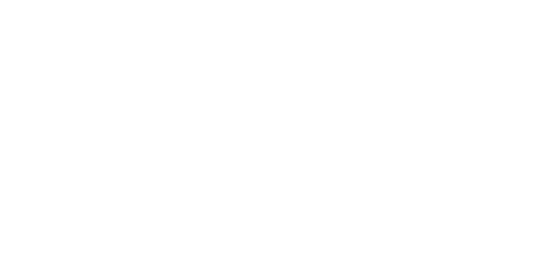

In [6]:
show("random_game")

## Example run mcts on a state

State(current_player=Array([0, 0], dtype=int32), observation=Array([[[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [ True, False],
         [False, False],
         [False, False],
         [False, False],
         [ True, False]],

        [[False, False],
         [False,  True],
         [False,  True],
         [False,  True],
         [ True, False],
         [False, False],
         [False,  True]]],


       [[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False,  True]],

        [[False,  True],
         [ True, False],
         [ True, False],
         [False, False],
         [ True, False],
         [False,  True],
         [False,  True]]]], dtype=bool), rewards=Array([[0., 0.],
       [0., 0.]], dtype=float32), terminated=Array([False, False], dtype=bool), truncated=Array([False, False], dtype=bool), legal_action_mask=Array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]], dtype=bool), _step_count=Array([7, 7], dtype=int32), _x=GameState(color=Array([1, 1], dtype=int32), board=Array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
        -1, -1,  1, -1,  0,  0,  0,  1, -1,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1,  0,  0,  1,  1, -1,  1,  0,  0]], dtype=int32), winner=Array([-1, -1], dtype=int32)))

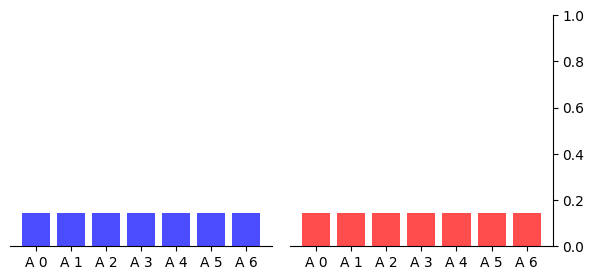

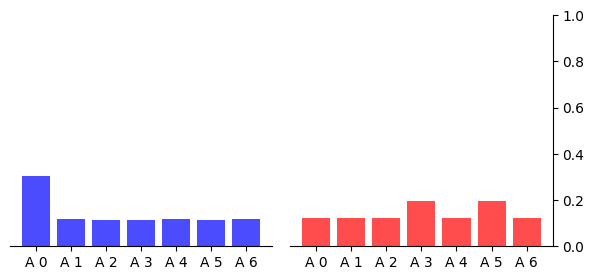

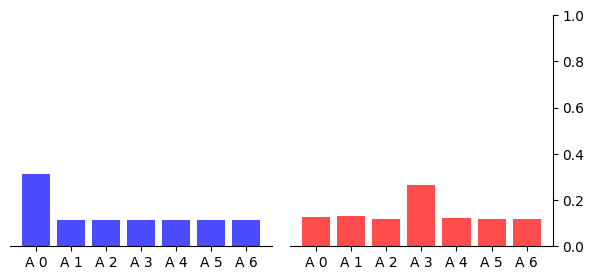

Value of the state: [-1. -1.]


In [7]:
random_state = states[7]
display(random_state)

subkey, key = jax.random.split(rng_key)
(prior, value) = mcts_rr.forward_fn(random_state, subkey)

plot_action_hist(jax.nn.softmax(prior))

subkey, key = jax.random.split(rng_key)
po100 = mcts_rr.run_mcts(100, random_state, subkey)
plot_action_hist(jax.nn.softmax(po100.action_weights))

subkey, key = jax.random.split(rng_key)
po1000 = mcts_rr.run_mcts(1000, random_state, subkey)
plot_action_hist(jax.nn.softmax(po1000.action_weights))

print("Value of the state:", value)

In [8]:
#winner, selfplayed_game = game(mcts_rr.play, mcts_rr.play)
#print("first player:", winner)
#save_animation(selfplayed_game, "mcts_rr_selfplay")

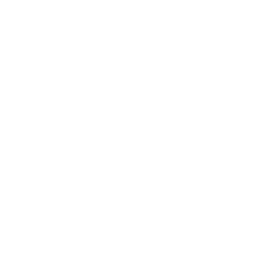

In [9]:
show("mcts_rr_selfplay")

# REINFORCE
This algorithm is the known REINFORCE algorithm with some improvement for stability, it does **not** contain the MCTS procedure.
It is a **policy based** algorithm.

1. selfplay: action selected with $\epsilon$-greedy based on the output logit of the neural network
2. shuffle samples and make minibatches
3. training: we tried different learning losses

**on policy**

In [10]:
import reinforce_v.reinforce_v as reinforce_v

### 1. **REINFORCE Loss**

$$
\text{policy\_loss} = - \mathbb{E} \left[ \log \hat{\pi}(a_t \mid S_t) \cdot G_t \cdot m_t \right]
$$

- $ \hat{\pi}(a_t \mid S_t) $: Policy network's probability of taking action $ a_t $ in state $ S_t $.
- $ G_t $: Return (cumulative discounted reward) from time step $ t $.
- $ m_t $: Mask indicating whether the trajectory is valid at time step $ t $.

---

### 2. **REINFORCE with Baseline**

$$
\text{policy\_loss} = - \mathbb{E} \left[ \log \hat{\pi}(a_t \mid S_t) \cdot A(S_t, a_t) \cdot m_t \right]
$$
where 
$$
A(S_t, a_t) = G_t - \hat{V}(S_t)
$$
- $ A(S_t, a_t) $: Advantage function, where $ \hat{V}(S_t) $ is the value network's estimate of the state value.

$$
\text{value\_loss} = \mathbb{E} \left[ \left( \hat{V}(S_t) - G_t \right)^2 \cdot m_t \right]
$$
- $ \hat{V}(S_t) $: Value network's estimate of the state value.
- $ G_t $: Return (cumulative discounted reward) from time step $ t $.

$$
L = \text{policy\_loss} + \text{value\_loss}
$$

---

### 3. **Entropy Regularization**

$$
\text{entropy\_loss} = - \mathbb{E} \left[ \left( - \sum_a \pi(a \mid s_t) \log \pi(a \mid s_t) \right) \cdot m_t \right]
$$

- $ \pi(a \mid s_t) $: Policy network's probability distribution over actions.
- $ m_t $: Mask indicating whether the trajectory is valid at time step $ t $.

$$
L = \text{policy\_loss} + \text{value\_loss} + 0.1 * \text{entropy\_loss}
$$

---

### 4. **Gradient Clipping**

To stabilize training, gradient clipping is applied to the optimizer. This ensures that the gradients do not exceed a specified threshold, preventing exploding gradients. The optimizer is defined as:

```python
optimizer = optax.chain(
    optax.clip_by_global_norm(0.5),  # Clip gradients to a maximum norm of 0.5
    optax.adam(learning_rate=config.learning_rate),  # Adam optimizer
)

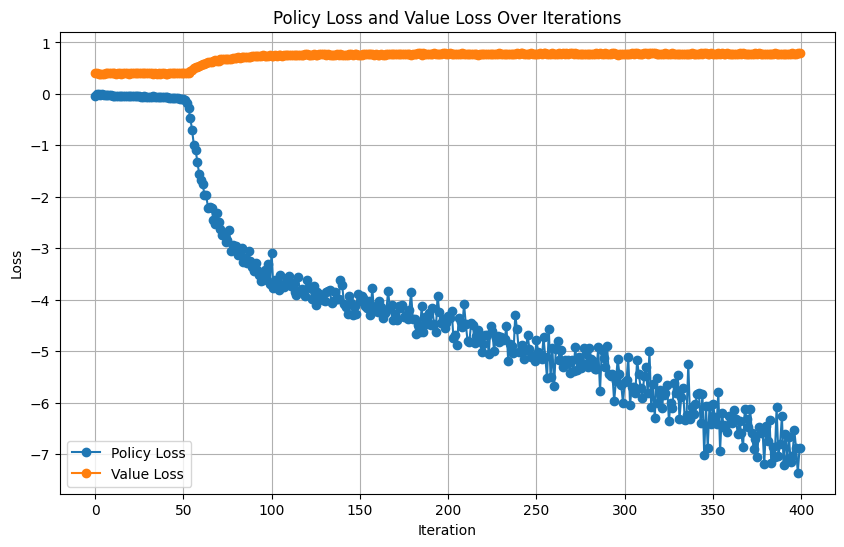

In [11]:
plot_losses("./reinforce_v/checkpoints/connect_four_20250131045019/training_log.json")

## DIVERGENCE

Even with all the loss improvement the loss still diverge.

We saw the deadly triad:

    1. boostrapping                 | no
    2. function approximation       | yes
    3. off policy                   | no batch

In [12]:
ckpt_dir = './reinforce_v/checkpoints/connect_four_20250131045019/'
iteration = 400  

r_model, opt_state, config, rng_key, frames, hours, pgx_version, env_id, env_version = load_model(ckpt_dir, iteration)

print(f"number of frames={frames}, hours={hours}")

number of frames=20480000, hours=0.28654134770234396


In [13]:
reinforce_v_play = partial(reinforce_v.play_model, r_model)

In [14]:
#winner, selfplayed_game = game(reinforce_v_play, reinforce_v_play)
#print("first player:", winner)
#save_animation(selfplayed_game, "reinforce_v_selfplay")

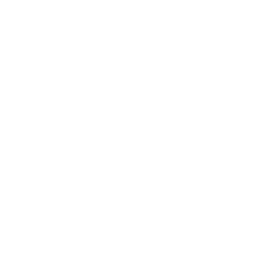

In [15]:
show("reinforce_v_selfplay")

In [16]:
#game(reinforce_v_play)

# ALPHAZERO

1. selfplay: MCTS with prior and value approximated by the neural network
2. shuffle samples and make minibatches
3. training

**on policy** batch

### Training Loss: 
$$
    L = \text{policy\_loss} + \text{value\_loss}
$$
where
$$
\text{value\_loss} = \mathbb{E} \left[ \left( \hat{V}(S_t) - G_t \right)^2 \cdot m_t \right]
$$
- $ \hat{V}(S_t) $: Value network's estimate of the state value.
- $ G_t $: Return (cumulative discounted reward) from time step $ t $.
and

$$
\text{policy\_loss} = - \mathbb{E} \left[ \sum_a \pi_{\text{target}}(a_t \mid S_t) \log \hat{\pi}(a_t \mid S_t) \right]
$$

- $ \pi_{\text{target}}(a_t \mid S_t) $: MCTS output policy.


In [17]:
import alphazero.alphazero as alphazero

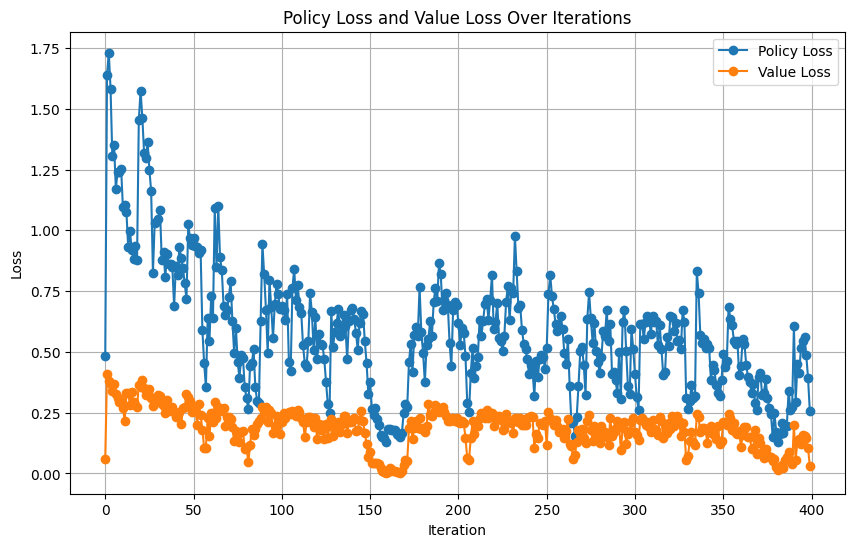

In [18]:
plot_losses("./alphazero/checkpoints/connect_four_20250131082521/training_log.json")

In [19]:
ckpt_dir = './alphazero/checkpoints/connect_four_20250131082521/'
iteration = 400  

az_model, opt_state, config, rng_key, frames, hours, pgx_version, env_id, env_version = load_model(ckpt_dir, iteration)

print(f"number of frames={frames}, hours={hours}")

number of frames=10240000, hours=1.3166861334111963


In [20]:
az_play = partial(alphazero.play_model_small, az_model)
az_mcts_play = partial(alphazero.play_mcts_model_small, az_model)

In [21]:
#winner, selfplayed_game = game(az_play, az_play)
#print("first player:", winner)
#save_animation(selfplayed_game, "alphazero_selfplay")

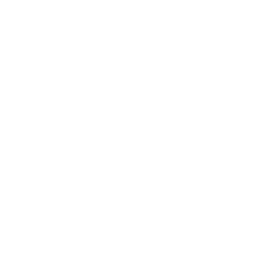

In [22]:
show("alphazero_selfplay")

In [23]:
#game(az_mcts_play)

### BETTER TRAINING

### 1) Smaller model

- model: Resnet - 5 layer, 64 channel
- mcts num simulation: **64**

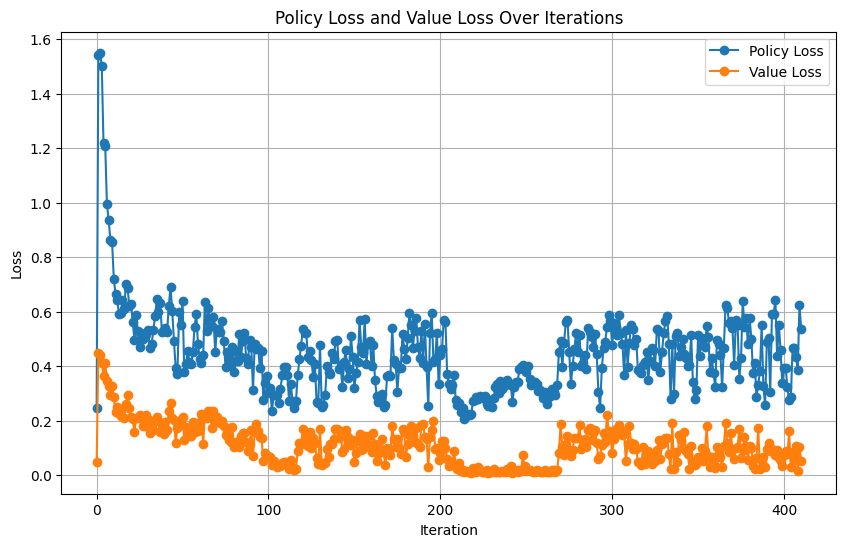

In [24]:
plot_losses("./alphazero/checkpoints/connect_four_5_64/training_log.json")

In [25]:
model_5_64 = load_model("./alphazero/checkpoints/connect_four_5_64/", 410)[0]

az_play_5_64 = partial(alphazero.play_model_small, model_5_64)
az_mcts_play_5_64 = partial(alphazero.play_mcts_model_small, model_5_64)

### 2) Bigger model 

- model: Resnet - 6 layer, 128 channel
- mcts num simulation: **128**

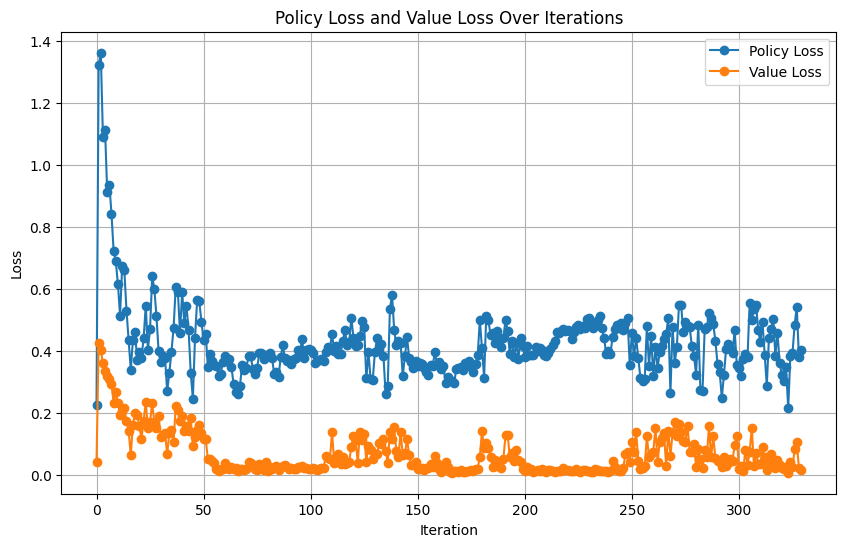

In [26]:
plot_losses("./alphazero/checkpoints/connect_four_6_128/training_log.json")

In [27]:
model_6_128 = load_model("./alphazero/checkpoints/connect_four_6_128/", 330)[0]

az_play_6_128 = partial(alphazero.play_model, model_6_128)
az_mcts_play_6_128 = partial(alphazero.play_mcts_model, model_6_128)

In [28]:
#game(az_mcts_play_6_128)

In [29]:
#winner, selfplayed_game = game(az_mcts_play_6_128, az_mcts_play_5_64)
#print("first player:", winner)
#save_animation(selfplayed_game, "alphazero_bigvssmall")

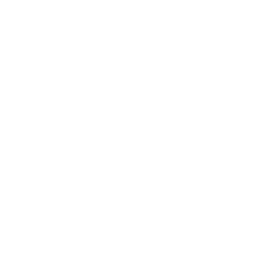

In [30]:
show("alphazero_bigvssmall")

In [31]:
winner, selfplayed_game = game(az_mcts_play_6_128)
print("first player:", winner)
save_animation(selfplayed_game, "alphazero_mevsbig3")

State(current_player=Array([1], dtype=int32), observation=Array([[[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]]]], dtype=bool), rewards=Array([[0., 0.]], dtype=float32), terminated=Array([False], dtype=bool), truncated=Array([False], dtype=bool), legal_action_mask=Array([[ True,  True,  True,  True,  True,  True,  True]], dtype=bool), _step_count=Array([0], dtype=int32), _x=GameState(color=Array([0], dtype=int32), board=Array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=int32), winner=Array([-1], dtype=int32)))

KeyboardInterrupt: Interrupted by user

In [ ]:
show("alphazero_mevsbig")

State(current_player=Array([0, 0], dtype=int32), observation=Array([[[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [ True, False],
         [False, False],
         [False, False],
         [False, False],
         [ True, False]],

        [[False, False],
         [False,  True],
         [False,  True],
         [False,  True],
         [ True, False],
         [False, False],
         [False,  True]]],


       [[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False],
         [False,  True]],

        [[False,  True],
         [ True, False],
         [ True, False],
         [False, False],
         [ True, False],
         [False,  True],
         [False,  True]]]], dtype=bool), rewards=Array([[0., 0.],
       [0., 0.]], dtype=float32), terminated=Array([False, False], dtype=bool), truncated=Array([False, False], dtype=bool), legal_action_mask=Array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]], dtype=bool), _step_count=Array([7, 7], dtype=int32), _x=GameState(color=Array([1, 1], dtype=int32), board=Array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
        -1, -1,  1, -1,  0,  0,  0,  1, -1,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1,  0,  0,  1,  1, -1,  1,  0,  0]], dtype=int32), winner=Array([-1, -1], dtype=int32)))

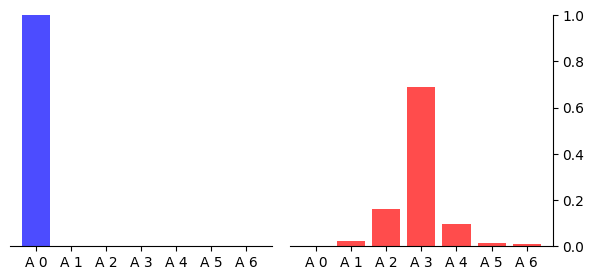

Array([-0.93581444,  0.85516936], dtype=float32)

In [32]:
model_params, model_state = model_6_128
(logits, value), _ = alphazero.forward.apply(
            model_params, model_state, random_state.observation, is_eval=True
        )
display(random_state)
plot_action_hist(jax.nn.softmax(logits))
value

## References

### Code Repositories
- **[JAX Framework](https://github.com/jax-ml/jax)** – A framework for high-performance machine learning research.
- **[pgx](https://github.com/jackc/pgx)** – A pure Go PostgreSQL driver and toolkit.
- **[mctx](https://github.com/google-deepmind/mctx)** – Monte Carlo tree search in JAX.
- **[Haiku](https://github.com/google-deepmind/dm-haiku)** – A simple neural network library for JAX.
- **[Optax](https://github.com/google-deepmind/optax)** – A gradient processing and optimization library for JAX.

### Papers

- Silver, David, et al. “A General Reinforcement Learning Algorithm That Masters Chess, Shogi, and Go through Self-Play.” Science, vol. 362, no. 6419, 6 Dec. 2018, pp. 1140–1144, https://doi.org/10.1126/science.aar6404.
- “Mastering the Game of Go with Deep Neural Networks and Tree Search.” Nature, vol. 529, no. 7587, Jan. 2016, pp. 484–489, www.nature.com/articles/nature16961, https://doi.org/10.1038/nature16961.
- “Mastering the Game of Go without Human Knowledge.” Nature, vol. 550, no. 7676, Oct. 2017, pp. 354–359, www.nature.com/articles/nature24270, https://doi.org/10.1038/nature24270. Accessed 21 Mar. 2019.
- Ivo Danihelka, et al. “Policy Improvement by Planning with Gumbel.” OpenReview, 2022, www.openreview.net/forum?id=bERaNdoegnO. Accessed 7 Feb. 2025.
- Koyamada, Sotetsu, et al. “Pgx: Hardware-Accelerated Parallel Game Simulators for Reinforcement Learning.” ArXiv.org, 2023, www.arxiv.org/abs/2303.17503. Accessed 7 Feb. 2025.